<a href="https://it-omscholing.nl/locaties/hogeschool-rotterdam/">
<div>
<a><img src='pics/banner.PNG'/></a>
</div>
<div>
<a href=''><img src='pics/miw.PNG'/></a>
<em>Author: Jeroen Boogaard</em>
</div>
</a>

<h1>Practicum SQL met <a href="https://geopandas.org/en/stable/index.html">GeoPandas</a></h1>
<img src="pics/geopandas_icon.png" width="25%" height="25%"/>

<h2>Environment Variables</h2>

In [6]:
import os
os.environ['export PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] ='notebook'
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'

<body> 
<h1 style="background-color:powderblue;color:red;font-size:150%">
Eerst Java apart installeren 
</h1>

</body>

In [7]:
#!(pip list | grep geopandas) || pip install geopandas
!pip install pyspark


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<h2>Imports<h2>

In [8]:
from pyspark import SparkContext as sc
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
import pyspark.sql
import pandas as pd
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import geopandas as gpd
#import geoplot
import numpy as np
import contextily as ctx

<h2>Data Visualization</h2>

<h3>Extract</h3>

In [9]:
data_dir = "geo/ref-nuts-2021-01m/"

euPath = data_dir + "NUTS_RG_01M_2021_3035_LEVL_1.json"
gdf = gpd.read_file(euPath)

<h3>Transform</h3>

In [10]:
gdf.crs = "EPSG:3035"
gdfBen = gdf[(gdf.CNTR_CODE == "BE") | (gdf.CNTR_CODE == "NL") | (gdf.CNTR_CODE == "LU")]
gdfCrsBen = gdfBen.to_crs("EPSG:3857")
gdfNl = gdf[gdf.CNTR_CODE == "NL"]
gdfCrsNl = gdfNl.to_crs("EPSG:3857")

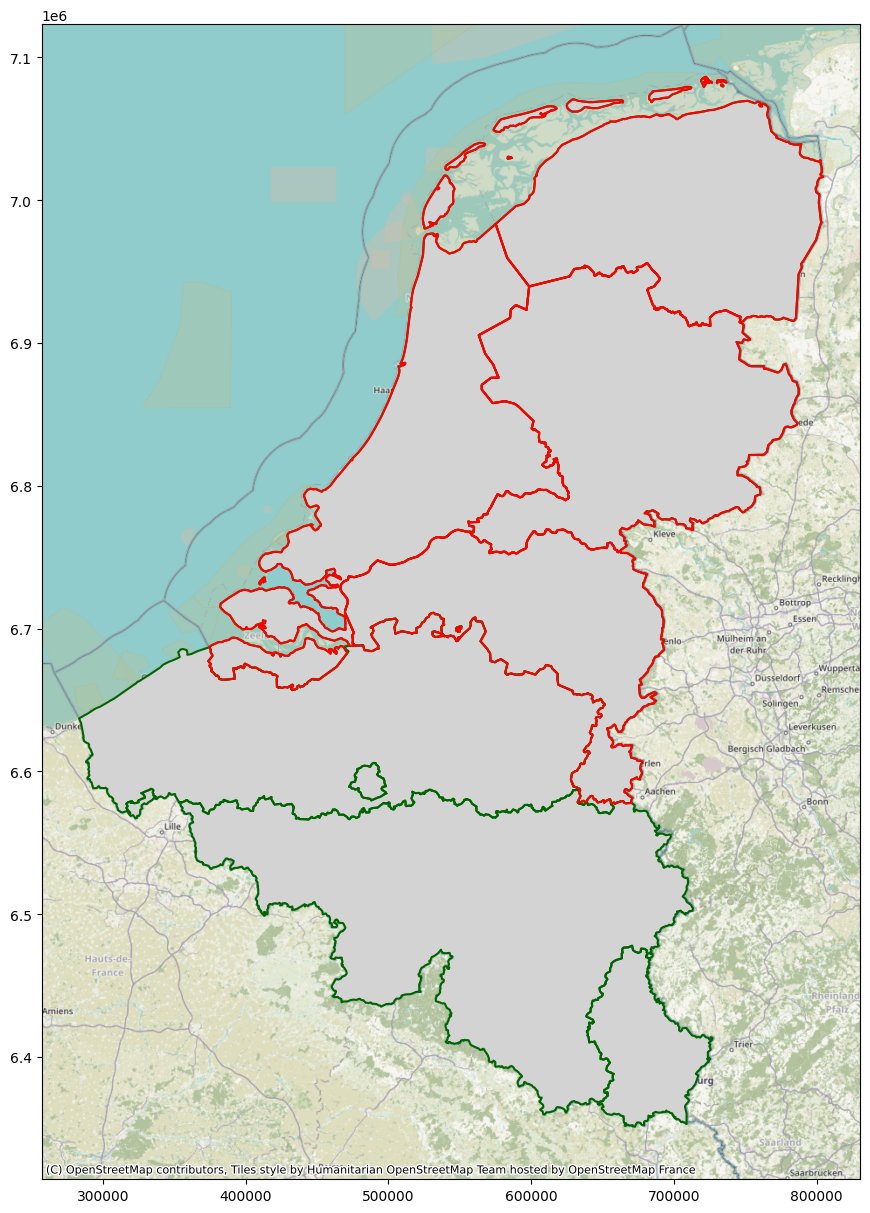

In [11]:
ax = gdfCrsBen.plot(figsize=(20,15), color="lightgray")

# Grenzen Benelux landen
gdfCrsBen.boundary.plot(color="darkgreen", ax=ax)

# Provincies Nederland
gdfCrsNl.boundary.plot(color="red", ax=ax)

# add background map by OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.HOT)

**Ingezoomed op de Benelux en Nederland gemarkeerd**

<h3>Transform</h3>

<h2>PySpark</h2>

Load

In [12]:
eurCsvFile = "csv/countries_europe.csv"
euCsvFile = "csv/european_union.csv"
eurCodesCsvFile = "csv/country-codes.csv"

In [13]:
# Create a Spark Session
spark = SparkSession.builder.appName('SQL').getOrCreate()

In [14]:
# Create Spark dataframe from csvfile
eurDf = spark.read.csv(eurCsvFile, inferSchema=True, header=True)
eurDf.printSchema()

root
 |-- zoom: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- abbreviation: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- ISO numeric: integer (nullable = true)
 |-- land area km: double (nullable = true)
 |-- population: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- continent: string (nullable = true)



FF Freewheelen

In [15]:
# Gebruik van filter
#dir(eurDf)
#help(eurDf.filter)
eurfilt = eurDf.filter(eurDf.population > 10000000)
eurfilt.select(['population','Code']).sort('population').show()


# maar kan ook met een sql function werken.
#  
when = pyspark.sql.functions.when
eurfilt2 = eurfilt.select('Code',when(eurfilt.population >20000000,1).otherwise(-1)).show()
print(eurfilt2)
#Ziet er ook wel grappig uit. 
#eurfilt.population.when()
#(eurfilt.population >20000000,1), 
#1)


+----------+----+
|population|Code|
+----------+----+
|  10403000| BEL|
|  10476000| CZE|
|  10676000| PRT|
|  11000000| GRC|
|  16645000| NLD|
|  21959278| ROU|
|  38500000| POL|
|  45415596| UKR|
|  46505963| ESP|
|  58145000| ITA|
|  62348447| GBR|
|  64768389| FRA|
|  82369000| DEU|
+----------+----+

+----+----------------------------------------------------+
|Code|CASE WHEN (population > 20000000) THEN 1 ELSE -1 END|
+----+----------------------------------------------------+
| UKR|                                                   1|
| FRA|                                                   1|
| ESP|                                                   1|
| DEU|                                                   1|
| POL|                                                   1|
| ITA|                                                   1|
| GBR|                                                   1|
| ROU|                                                   1|
| GRC|                           

In [16]:
# Create a view. 
eurDf.createOrReplaceTempView('countries')
help(eurDf.createOrReplaceTempView)
#Wat is dit? Ik snap het eigenlijk nog steeds niet. 

Help on method createOrReplaceTempView in module pyspark.sql.dataframe:

createOrReplaceTempView(name: str) -> None method of pyspark.sql.dataframe.DataFrame instance
    Creates or replaces a local temporary view with this :class:`DataFrame`.
    
    The lifetime of this temporary table is tied to the :class:`SparkSession`
    that was used to create this :class:`DataFrame`.
    
    .. versionadded:: 2.0.0
    
    Examples
    --------
    >>> df.createOrReplaceTempView("people")
    >>> df2 = df.filter(df.age > 3)
    >>> df2.createOrReplaceTempView("people")
    >>> df3 = spark.sql("select * from people")
    >>> sorted(df3.collect()) == sorted(df2.collect())
    True
    >>> spark.catalog.dropTempView("people")
    True



**query op het dataframe via <i>methods</i>**

In [17]:
eurDf.select("Code").show(10)

+----+
|Code|
+----+
| UKR|
| FRA|
| ESP|
| SWE|
| DEU|
| FIN|
| NOR|
| POL|
| ITA|
| GBR|
+----+
only showing top 10 rows



**<i>SQL</i> query op het dataframe**

In [18]:
import time
s= time.time()
eurDf.select('Code').show(10)
e= time.time()
print(e-s)

+----+
|Code|
+----+
| UKR|
| FRA|
| ESP|
| SWE|
| DEU|
| FIN|
| NOR|
| POL|
| ITA|
| GBR|
+----+
only showing top 10 rows

0.08310103416442871


In [19]:



s= time.time()
countriesQuery = """
    SELECT Code
    FROM countries
"""

eurCodes = spark.sql(countriesQuery)
eurCodes.show(10)
e = time.time()
print(e-s)


+----+
|Code|
+----+
| UKR|
| FRA|
| ESP|
| SWE|
| DEU|
| FIN|
| NOR|
| POL|
| ITA|
| GBR|
+----+
only showing top 10 rows

0.12144351005554199


In [20]:
eurDf.select("Code").show(10)

+----+
|Code|
+----+
| UKR|
| FRA|
| ESP|
| SWE|
| DEU|
| FIN|
| NOR|
| POL|
| ITA|
| GBR|
+----+
only showing top 10 rows



In [21]:
#eurDf.write.json('C:/temp/test.json')
# Wegschrijven werkt niet. Op stackoverflow kom ik vage meldingen tegen met advies om hadoop files aan te passen

AnalysisException: path file:/C:/temp/test.json already exists.

<h3>Exercise 1</h3>
<p>
Maak op dezelfde manier dataframes euDf en eurCodesDf aan door het importeren vanuit de csv-files
</p>

In [22]:

#eurCsvFile = "csv/countries_europe.csv"
#euCsvFile = "csv/european_union.csv"
#eurCodesCsvFile = "csv/country-codes.csv"
eurCsvDf = spark.read.csv(eurCsvFile, inferSchema=True, header=True)
euCsvDf = spark.read.csv(euCsvFile, inferSchema=True, header=True)
cCodesDf = spark.read.csv(eurCodesCsvFile, inferSchema=True, header=True)
cCodesDf.printSchema()
eurCsvDf.printSchema()
help(cCodesDf['FIFA'])


root
 |-- FIFA: string (nullable = true)
 |-- Dial: string (nullable = true)
 |-- ISO3166-1-Alpha-3: string (nullable = true)
 |-- MARC: string (nullable = true)
 |-- is_independent: string (nullable = true)
 |-- ISO3166-1-numeric: integer (nullable = true)
 |-- GAUL: string (nullable = true)
 |-- FIPS: string (nullable = true)
 |-- WMO: string (nullable = true)
 |-- ISO3166-1-Alpha-2: string (nullable = true)
 |-- ITU: string (nullable = true)
 |-- IOC: string (nullable = true)
 |-- DS: string (nullable = true)
 |-- UNTERM Spanish Formal: string (nullable = true)
 |-- Global Code: boolean (nullable = true)
 |-- Intermediate Region Code: integer (nullable = true)
 |-- official_name_fr: string (nullable = true)
 |-- UNTERM French Short: string (nullable = true)
 |-- ISO4217-currency_name: string (nullable = true)
 |-- Developed / Developing Countries: string (nullable = true)
 |-- UNTERM Russian Formal: string (nullable = true)
 |-- UNTERM English Short: string (nullable = true)
 |-- IS

<h3>Exercise 2a</h3>
<p>
    Maak een <u>koppeling</u> tussen <u>euDf</u> en <u>eurCodesDf</u> via kolom <u>Code</u> en <u>ISO3166-1-Alpha-3</u> 
</p>

In [23]:
# Oplossing
# zoeken op internet levert op dat samenvoegen met de methode join kan. 
#

eulargeDf = euCsvDf.join(cCodesDf,euCsvDf['Code']==cCodesDf['ISO3166-1-Alpha-3'])
eulargeDf['Code','ISO3166-1-Alpha-3'].show(10)
eulargeDf['WMO',].show(10)
eulargeDf.printSchema()

# lengte (aantal rijen) achterhalen kan met de methode count.
print(eulargeDf.count())
print(euCsvDf.count())
print(cCodesDf.count())


+----+-----------------+
|Code|ISO3166-1-Alpha-3|
+----+-----------------+
| AUT|              AUT|
| BEL|              BEL|
| BGR|              BGR|
| HRV|              HRV|
| CYP|              CYP|
| CZE|              CZE|
| DNK|              DNK|
| EST|              EST|
| FIN|              FIN|
| FRA|              FRA|
+----+-----------------+
only showing top 10 rows

+---+
|WMO|
+---+
| OS|
| BX|
| BU|
| RH|
| CY|
| CZ|
| DN|
| EO|
| FI|
| FR|
+---+
only showing top 10 rows

root
 |-- Code: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Member-Since: timestamp (nullable = true)
 |-- FIFA: string (nullable = true)
 |-- Dial: string (nullable = true)
 |-- ISO3166-1-Alpha-3: string (nullable = true)
 |-- MARC: string (nullable = true)
 |-- is_independent: string (nullable = true)
 |-- ISO3166-1-numeric: integer (nullable = true)
 |-- GAUL: string (nullable = true)
 |-- FIPS: string (nullable = true)
 |-- WMO: string (nullable = true)
 |-- ISO3166-1-Alpha-2: string

<h3>Exercise 2b</h3>

<h4>Gegeven</h4>

<p>De dataset gdf bevat tweeletterige landcodes die je ook kunt terugvinden in de dataset <u>eurCodesDf</u></>

In [24]:
gdf.CNTR_CODE.tolist()[:10]

['CY', 'DE', 'CH', 'FR', 'BG', 'DE', 'EL', 'EL', 'DE', 'BE']

<h4>Gevraagd</h4>
<p>
    Maak een geopandas dataframe <u>gdfEu</u> gebaseerd op <u>gdf</u> en markeer hierin de EU landen met <span style="color:red">rood</span>.
    <strong>Hint</strong>Gebruik de koppeling uit 2a voor het verkrijgen van de tweeletterige landcodes van EU landen en filter daarmee het geodataframe.
</p>

<h4>Oplossing</h4>

In [96]:
ladiela  =eulargeDf.select(eulargeDf.FIFA.startswith('A').alias('yo'))
print(ladiela)
ladiela.show()


DataFrame[yo: boolean]
+-----+
|   yo|
+-----+
| true|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
+-----+
only showing top 20 rows



In [100]:
# Oplossing
if False:
    print(eulargeDf.columns)

    #je kan koppelen met de spark database via een ISO-norm.
    # Maar welke dan  
    # Eerst even kijken welke iso data er zijn 
    #eulargeDf.select(eulargeDf.columns.filter(_.startsWith("ISO")).map(eulargeDf(_)) : _*).show
    # Dit werkt niet.
    # kijken of het met map kan..
    def isoinname(s):
        if 'ISO' in s:
            return s
    x=map(isoinname, eulargeDf.columns)
    for a in x:
        print(a)

    # ...filter werkt nog beter.
    y=filter(isoinname, eulargeDf.columns)
    for b in y:
        print(b)

    # 'ISO3166-1-Alpha-2'
    #eulargeDf.columns.filter

print(eulargeDf['ISO3166-1-Alpha-2',].show(10))
tempsdf = eulargeDf['ISO3166-1-Alpha-2',]
tempdf= tempsdf.toPandas()
eulargeDf
tempsdf.columns
print(gdf.keys())
print(gdf['CNTR_CODE'])
print(tempsdf['ISO3166-1-Alpha-2'])


for a in tempdf['ISO3166-1-Alpha-2']:
    print(gdf[gdf['CNTR_CODE'] ==a] ) 

ending = [gdf[gdf['CNTR_CODE'] ==a] for a in tempdf['ISO3166-1-Alpha-2']] 

print(ending)

#print(tempdf['ISO3166-1-Alpha-2'][1] in gdf['CNTR_CODE'] )
#gdf[gdf['CNTR_CODE']==tempsdf['ISO3166-1-Alpha-2']]
#gdf




+-----------------+
|ISO3166-1-Alpha-2|
+-----------------+
|               AT|
|               BE|
|               BG|
|               HR|
|               CY|
|               CZ|
|               DK|
|               EE|
|               FI|
|               FR|
+-----------------+
only showing top 10 rows

None
Index(['id', 'NUTS_ID', 'LEVL_CODE', 'CNTR_CODE', 'NAME_LATN', 'NUTS_NAME',
       'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE', 'FID', 'geometry'],
      dtype='object')
0      CY
1      DE
2      CH
3      FR
4      BG
       ..
120    TR
121    TR
122    TR
123    TR
124    NO
Name: CNTR_CODE, Length: 125, dtype: object
Column<'ISO3166-1-Alpha-2'>
     id NUTS_ID  LEVL_CODE CNTR_CODE       NAME_LATN       NUTS_NAME  \
32  AT1     AT1          1        AT   Ostösterreich   Ostösterreich   
33  AT2     AT2          1        AT   Südösterreich   Südösterreich   
45  AT3     AT3          1        AT  Westösterreich  Westösterreich   

    MOUNT_TYPE  URBN_TYPE  COAST_TYPE  FID  \
32    

AttributeError: 'list' object has no attribute 'shape'

['attribution', 'html_attribution', 'max_zoom', 'name', 'url']

In [139]:
os.getcwd()
#print(os.listdir())
print(end.crs.to_string())

EPSG:3035


c:\Users\marcr\MakeAIWork3\env_geopan\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


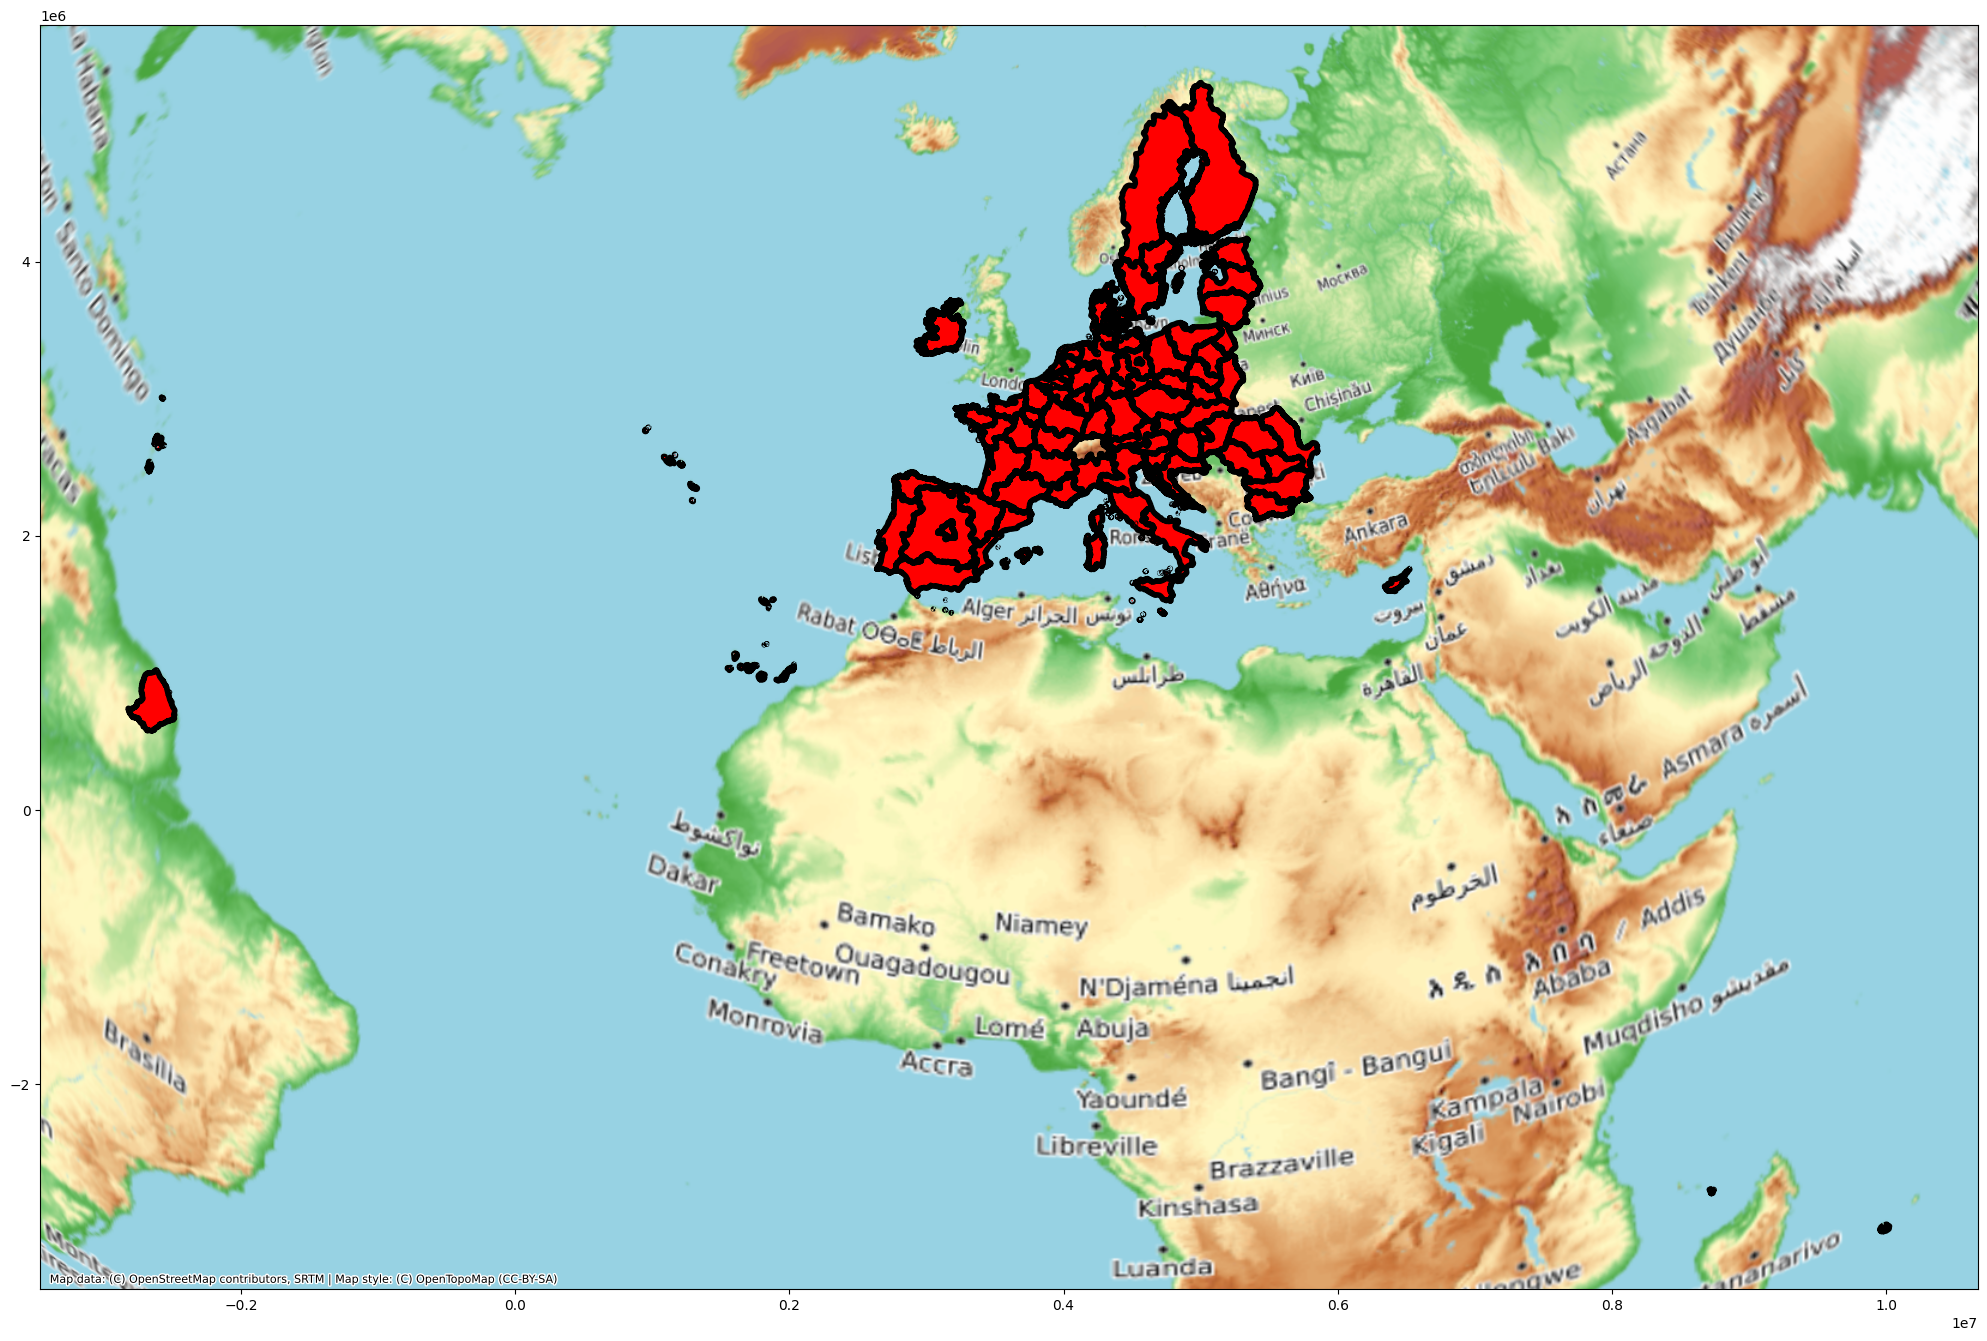

In [142]:
gdf[gdf['CNTR_CODE'] ==a].shape
plt.figure(figsize=[25,18])
ax=plt.gca()
source = ctx.providers.OpenTopoMap

#ctx.plot_map(ax=ax,place=pl,axis_off=False,crs='EPSG:3857') # crs kun je alleen opgeven in add_basemap?
if True:
    for end in ending:
        end.plot(color='red',ax=ax,edgecolor='k',linewidth=4)
#ctx.add_basemap(ax=ax,crs='EPSG:3035',source=source,zoom=3)
ctx.add_basemap(ax=ax,crs=end.crs,source=source,zoom=3)

pl = ctx.place.Place('europa',source=source,path='europa.tif')

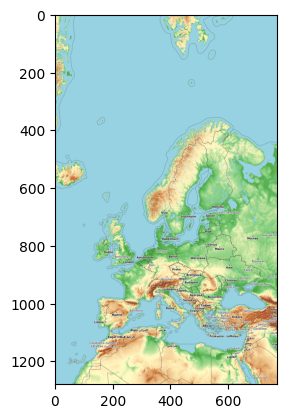

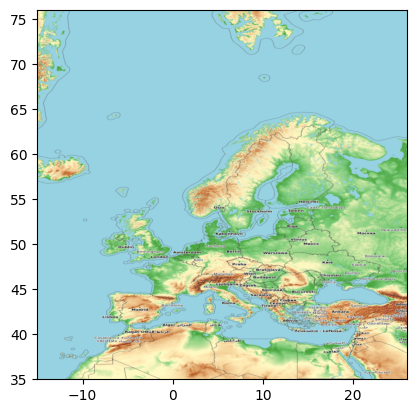

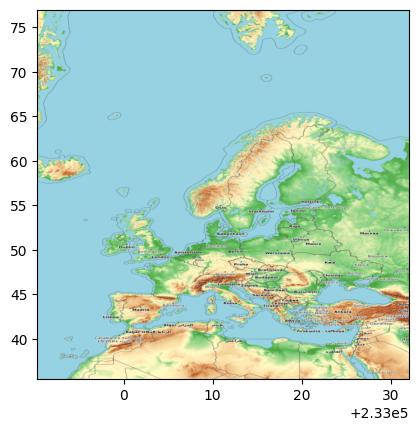

In [164]:
#ruw plotten van een tif afkomstig uit contextily.Place object
pl = ctx.place.Place('europa',source=source,path='europa.tif')
im = plt.imread('europa.tif')
plt.imshow(im)

# naar pseudo mercator 
plt.figure()
im_new = ctx.warp_tiles(im[:,:,:4],pl.bbox,t_crs="epsg:3857")
plt.imshow(im_new[0],extent=im_new[1])

plt.figure()
im_new = ctx.warp_tiles(im[:,:,:4],pl.bbox,t_crs="epsg:3025")
plt.imshow(im_new[0],extent=im_new[1])



**References**
<ul>
    <li>        
        <a href="https://towardsdatascience.com/pyspark-and-sparksql-basics-6cb4bf967e53">Pyspark SQL basics</a>       
    </li>
    <li>
        <a href="https://ec.europa.eu/eurostat/web/main/home">Eurostat</a>
    </li>
</ul>    